In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from PIL import Image
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2

C:\Users\95kes\python\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\95kes\python\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\95kes\python\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


### Adding images and converting to numpy array

In [3]:
directory = os.path.join('dataset','training_shuffle_400,a')

In [4]:
def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='png'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

In [5]:
train_datagen = ImageDataGenerator(zca_whitening=True,validation_split = .2)
test_datagen = ImageDataGenerator(zca_whitening=True)

C:\Users\95kes\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [35]:
x = load_all_images(os.path.join('dataset','small_train_sample'),64,64)

train_datagen.fit(x)
test_datagen.fit(x)

In [ ]:
training_set = train_datagen.flow_from_directory(
    directory,target_size=(64, 64),batch_size=64,class_mode='categorical', shuffle = True,subset='training'
)

validation_set = train_datagen.flow_from_directory(directory,
                                        target_size=(64, 64),
                                                 batch_size=64,
                                      class_mode='categorical',
                                               shuffle = True,
                                           subset='validation')

test_set = test_datagen.flow_from_directory(os.path.join('dataset','test_random'),
                                                target_size=(64, 64),
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle = True)

Found 6190 images belonging to 24 classes.
Found 1536 images belonging to 24 classes.
Found 240 images belonging to 24 classes.


In [1]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = training_set.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image[0])
# show the figure
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Model architechture
model = Sequential()
# The first two layers with 32 filters of window size 3x3
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                        

In [ ]:
patience = 1
stop_patience = 4
factor = 0.5
checkpoint_path = "training_2_zca/=.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
]


In [ ]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(training_set,epochs=30,validation_data = validation_set,verbose=1,callbacks=callbacks)

Epoch 1/30
97/97 [==============================] - ETA: 0s - loss: 2.8676 - accuracy: 0.1378
Epoch 00001: saving model to training_2_zca\=.ckpt
97/97 [==============================] - 315s 3s/step - loss: 2.8676 - accuracy: 0.1378 - val_loss: 1.8801 - val_accuracy: 0.4408
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 1.6062 - accuracy: 0.5121
Epoch 00002: saving model to training_2_zca\=.ckpt
97/97 [==============================] - 301s 3s/step - loss: 1.6062 - accuracy: 0.5121 - val_loss: 1.0084 - val_accuracy: 0.6895
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 0.9838 - accuracy: 0.6943
Epoch 00003: saving model to training_2_zca\=.ckpt
97/97 [==============================] - 299s 3s/step - loss: 0.9838 - accuracy: 0.6943 - val_loss: 0.6631 - val_accuracy: 0.7936
Epoch 4/30
97/97 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7932
Epoch 00004: saving model to training_2_zca\=.ckpt
97/97 [=======================

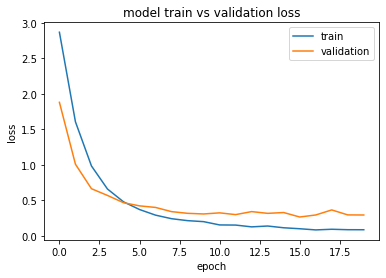

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

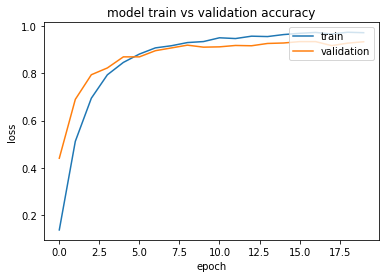

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(test_set)

4/4 [==============================] - 10s 2s/step - loss: 25.6813 - accuracy: 0.1625


[25.681306838989258, 0.16249999403953552]

In [ ]:
test_set.reset()
pred = model.predict(test_set)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_set.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [ ]:
results.head(15)

,Filename,Predictions
0,a\Person_E_color_0_0003.png,h
1,a\Person_E_color_0_0030.png,b
2,a\Person_E_color_0_0078.png,f
3,a\Person_E_color_0_0145.png,l
4,a\Person_E_color_0_0202.png,f
5,a\Person_E_color_0_0276.png,h
6,a\Person_E_color_0_0277.png,f
7,a\Person_E_color_0_0431.png,e
8,a\Person_E_color_0_0467.png,l
9,a\Person_E_color_0_0471.png,n
